# Boolean Functions as Random Variables

**Reference: O'Donnell, Chapters 1-3**

This notebook explores the probabilistic view of Boolean functions, demonstrating how to:

1. View Boolean functions as random variables on the hypercube
2. Sample from uniform and p-biased distributions
3. Sample from the Fourier (spectral) distribution
4. Estimate Fourier coefficients via Monte Carlo
5. Verify convergence and the law of large numbers

---

## Key Concepts (from O'Donnell)

- A Boolean function $f: \{-1,+1\}^n \to \{-1,+1\}$ is a **random variable** when inputs are drawn uniformly
- $\mathbb{E}[f] = \hat{f}(\emptyset)$ (the Fourier coefficient on the empty set)
- $\text{Var}[f] = \sum_{S \neq \emptyset} \hat{f}(S)^2$ by Parseval
- The **spectral distribution** has $\Pr[S] = \hat{f}(S)^2$ (for $\pm 1$-valued $f$)

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf

# Import the sampling module
from boofun.analysis.sampling import (
    sample_uniform,
    sample_biased,
    sample_spectral,
    sample_input_output_pairs,
    estimate_fourier_coefficient,
    estimate_influence,
    estimate_total_influence,
    RandomVariableView,
    SpectralDistribution,
)

# For reproducibility
np.random.seed(42)

print("boofun version:", bf.__version__)

boofun version: 1.1.1


## 1. Sampling from the Hypercube

### 1.1 Uniform Sampling

The most basic operation is sampling uniformly from $\{0,1\}^n$, equivalent to choosing each bit independently with probability $1/2$.

In [3]:
# Sample 10 random inputs for n=4 variables
n = 4
samples = sample_uniform(n, n_samples=10)

print(f"10 uniform samples from {{0,1}}^{n}:")
for x in samples:
    bits = f"{x:0{n}b}"
    print(f"  {x:2d} = {bits}")

10 uniform samples from {0,1}^4:
   7 = 0111
   8 = 1000
   5 = 0101
   8 = 1000
  13 = 1101
   5 = 0101
  10 = 1010
  15 = 1111
   0 = 0000
   8 = 1000


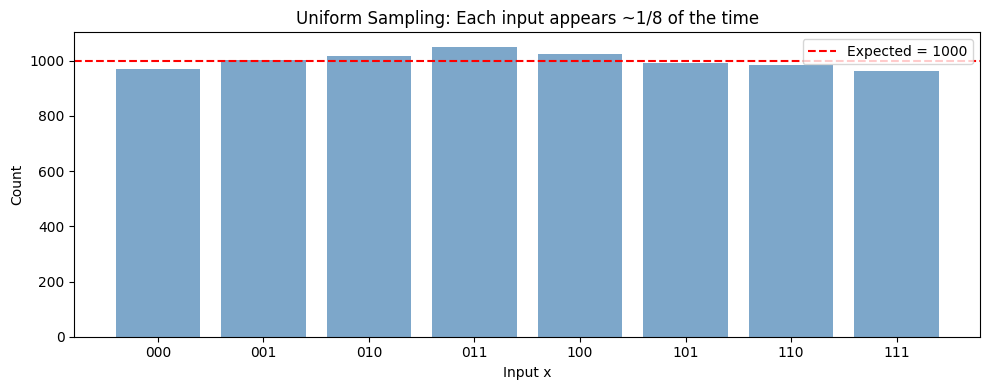

In [4]:
# Verify uniformity: each input should appear roughly equally often
n = 3
samples = sample_uniform(n, n_samples=8000)
counts = np.bincount(samples, minlength=8)

plt.figure(figsize=(10, 4))
plt.bar(range(8), counts, color='steelblue', alpha=0.7)
plt.axhline(y=1000, color='red', linestyle='--', label=f'Expected = 1000')
plt.xlabel('Input x')
plt.ylabel('Count')
plt.title('Uniform Sampling: Each input appears ~1/8 of the time')
plt.xticks(range(8), [f"{x:03b}" for x in range(8)])
plt.legend()
plt.tight_layout()
plt.show()

### 1.2 P-Biased Sampling

The **$p$-biased distribution** $\mu_p$ sets each bit to 1 independently with probability $p$.

- $p = 0.5$: Uniform distribution
- $p < 0.5$: More zeros than ones
- $p > 0.5$: More ones than zeros

In [5]:
# Compare p=0.2, p=0.5, p=0.8 distributions
n = 8
n_samples = 5000

def avg_hamming_weight(samples, n):
    """Average number of 1 bits."""
    return np.mean([bin(x).count('1') for x in samples])

for p in [0.2, 0.5, 0.8]:
    samples = sample_biased(n, p, n_samples)
    avg_ones = avg_hamming_weight(samples, n)
    expected = p * n
    print(f"p={p:.1f}: Average #ones = {avg_ones:.2f} (expected {expected:.2f})")

p=0.2: Average #ones = 1.61 (expected 1.60)
p=0.5: Average #ones = 3.99 (expected 4.00)
p=0.8: Average #ones = 6.37 (expected 6.40)


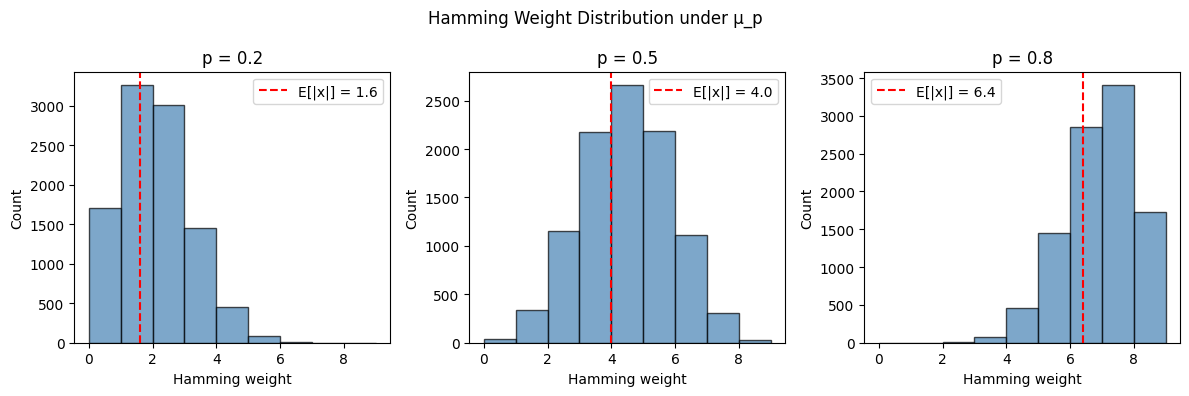

In [6]:
# Visualize the distribution of Hamming weights
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

n = 8
for ax, p in zip(axes, [0.2, 0.5, 0.8]):
    samples = sample_biased(n, p, 10000)
    weights = [bin(x).count('1') for x in samples]
    
    ax.hist(weights, bins=range(n+2), alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(x=p*n, color='red', linestyle='--', label=f'E[|x|] = {p*n}')
    ax.set_xlabel('Hamming weight')
    ax.set_ylabel('Count')
    ax.set_title(f'p = {p}')
    ax.legend()

plt.suptitle('Hamming Weight Distribution under μ_p')
plt.tight_layout()
plt.show()

## 2. Sampling Input-Output Pairs

Given a Boolean function $f$, we can sample $(x, f(x))$ pairs. This is the foundation of Monte Carlo estimation.

In [7]:
# Sample from the AND function
f = bf.AND(3)
inputs, outputs = sample_input_output_pairs(f, n_samples=20)

print("Samples from AND₃:")
print(f"{'Input':<10} {'Binary':<10} {'f(x)':<5}")
print("-" * 25)
for x, y in zip(inputs[:10], outputs[:10]):
    print(f"{x:<10} {x:03b}        {y}")

# Estimate E[f] = Pr[AND(x) = 1] (should be 1/8 = 0.125)
print(f"\nEstimated Pr[AND₃ = 1] = {np.mean(outputs):.3f} (exact: 0.125)")

Samples from AND₃:
Input      Binary     f(x) 
-------------------------
1          001        0
0          000        0
1          001        0
0          000        0
4          100        0
0          000        0
2          010        0
1          001        0
2          010        0
7          111        1

Estimated Pr[AND₃ = 1] = 0.100 (exact: 0.125)


## 3. Spectral Sampling

**Spectral sampling** draws subsets $S$ with probability proportional to $\hat{f}(S)^2$.

For a $\pm 1$-valued function, Parseval says $\sum_S \hat{f}(S)^2 = 1$, so this is a valid distribution.

This is useful for:
- Finding **heavy Fourier coefficients**
- **Learning algorithms** (Goldreich-Levin)
- Understanding **spectral structure**

In [8]:
# XOR has all Fourier weight on the full set {0,1}
xor = bf.create([0, 1, 1, 0])
samples = sample_spectral(xor, n_samples=100)

print("Spectral samples from XOR:")
unique, counts = np.unique(samples, return_counts=True)
for s, c in zip(unique, counts):
    bits = [i for i in range(2) if (s >> i) & 1]
    set_str = "{" + ",".join(map(str, bits)) + "}" if bits else "∅"
    print(f"  S = {set_str}: {c}% of samples")

print("\n→ XOR concentrates all spectral weight on S = {0,1} (the full set)")

Spectral samples from XOR:
  S = {0,1}: 100% of samples

→ XOR concentrates all spectral weight on S = {0,1} (the full set)


In [9]:
# AND has weight spread across multiple subsets
f = bf.AND(3)
samples = sample_spectral(f, n_samples=1000)

# Get exact Fourier coefficients for comparison
fourier = f.fourier()

print("Spectral distribution of AND₃:")
print(f"{'Subset':<12} {'f̂(S)²':<10} {'Sampled %':<10}")
print("-" * 35)

unique, counts = np.unique(samples, return_counts=True)
sampled_freq = dict(zip(unique, counts / 1000))

for s in range(8):
    bits = [i for i in range(3) if (s >> i) & 1]
    set_str = "{" + ",".join(map(str, bits)) + "}" if bits else "∅"
    exact = fourier[s]**2
    sampled = sampled_freq.get(s, 0)
    if exact > 0.001 or sampled > 0.001:
        print(f"{set_str:<12} {exact:<10.4f} {sampled*100:<10.1f}%")

Spectral distribution of AND₃:
Subset       f̂(S)²     Sampled % 
-----------------------------------
∅            0.5625     53.9      %
{0}          0.0625     7.3       %
{1}          0.0625     7.6       %
{0,1}        0.0625     7.6       %
{2}          0.0625     5.8       %
{0,2}        0.0625     5.7       %
{1,2}        0.0625     6.0       %
{0,1,2}      0.0625     6.1       %


## 4. Monte Carlo Estimation of Fourier Coefficients

The Fourier coefficient $\hat{f}(S)$ satisfies:

$$\hat{f}(S) = \mathbb{E}_x[f(x) \chi_S(x)]$$

where $\chi_S(x) = (-1)^{\langle x, S \rangle}$.

We can **estimate** this by sampling:

$$\hat{f}(S) \approx \frac{1}{N} \sum_{i=1}^{N} f(x_i) \chi_S(x_i)$$

In [10]:
# Estimate Fourier coefficients of AND₃
f = bf.AND(3)
exact_fourier = f.fourier()

print("Monte Carlo estimation of AND₃ Fourier coefficients:")
print(f"{'Subset':<12} {'Exact f̂(S)':<12} {'Estimated':<12} {'Error':<10}")
print("-" * 50)

for s in range(8):
    bits = [i for i in range(3) if (s >> i) & 1]
    set_str = "{" + ",".join(map(str, bits)) + "}" if bits else "∅"
    
    exact = exact_fourier[s]
    est = estimate_fourier_coefficient(f, s, n_samples=10000)
    error = abs(exact - est)
    
    print(f"{set_str:<12} {exact:<12.4f} {est:<12.4f} {error:<10.4f}")

Monte Carlo estimation of AND₃ Fourier coefficients:
Subset       Exact f̂(S)  Estimated    Error     
--------------------------------------------------


∅            0.7500       0.7402       0.0098    
{0}          0.2500       0.2462       0.0038    
{1}          0.2500       0.2496       0.0004    


{0,1}        -0.2500      -0.2566      0.0066    


{2}          0.2500       0.2506       0.0006    
{0,2}        -0.2500      -0.2528      0.0028    
{1,2}        -0.2500      -0.2530      0.0030    
{0,1,2}      0.2500       0.2552       0.0052    


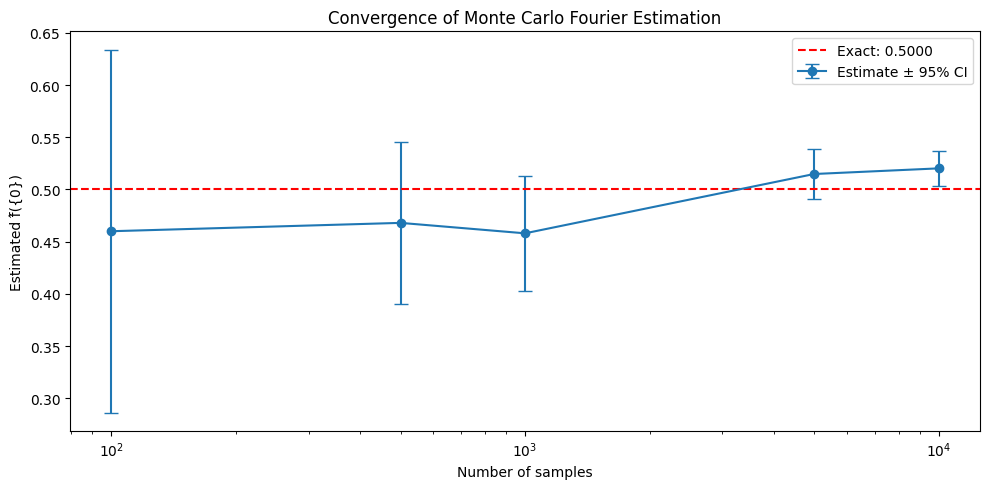


As N → ∞, estimate → exact value 0.5000
Error scales as O(1/√N) by Central Limit Theorem


In [11]:
# Show convergence with confidence intervals
f = bf.majority(3)
S = 1  # Coefficient on {0}
exact = f.fourier()[S]

sample_sizes = [100, 500, 1000, 5000, 10000]
estimates = []
errors = []

for n in sample_sizes:
    est, std_err = estimate_fourier_coefficient(f, S, n_samples=n, return_confidence=True)
    estimates.append(est)
    errors.append(1.96 * std_err)  # 95% CI

plt.figure(figsize=(10, 5))
plt.errorbar(sample_sizes, estimates, yerr=errors, fmt='o-', capsize=5, label='Estimate ± 95% CI')
plt.axhline(y=exact, color='red', linestyle='--', label=f'Exact: {exact:.4f}')
plt.xlabel('Number of samples')
plt.ylabel('Estimated f̂({0})')
plt.title('Convergence of Monte Carlo Fourier Estimation')
plt.legend()
plt.xscale('log')
plt.tight_layout()
plt.show()

print(f"\nAs N → ∞, estimate → exact value {exact:.4f}")
print("Error scales as O(1/√N) by Central Limit Theorem")

## 5. Influence Estimation

The **influence** of variable $i$ is:

$$\text{Inf}_i[f] = \Pr_x[f(x) \neq f(x^{\oplus i})]$$

where $x^{\oplus i}$ flips the $i$-th bit of $x$.

In [12]:
# Estimate influences of MAJORITY₅
f = bf.majority(5)
exact_influences = f.influences()

print("Influence estimation for MAJORITY₅:")
print(f"{'Variable':<10} {'Exact':<12} {'Estimated':<12} {'Error':<10}")
print("-" * 45)

for i in range(5):
    exact = exact_influences[i]
    est, std_err = estimate_influence(f, i, n_samples=10000, return_confidence=True)
    error = abs(exact - est)
    print(f"Inf_{i}       {exact:<12.4f} {est:<12.4f} {error:<10.4f}")

print("\n→ All variables have equal influence (MAJORITY is symmetric)")

Influence estimation for MAJORITY₅:
Variable   Exact        Estimated    Error     
---------------------------------------------
Inf_0       0.3750       0.3770       0.0020    
Inf_1       0.3750       0.3810       0.0060    


Inf_2       0.3750       0.3849       0.0099    
Inf_3       0.3750       0.3718       0.0032    
Inf_4       0.3750       0.3790       0.0040    

→ All variables have equal influence (MAJORITY is symmetric)


In [13]:
# Total influence estimation
f = bf.majority(5)
exact_total = f.total_influence()
est_total = estimate_total_influence(f, n_samples=10000)

print(f"Total influence of MAJORITY₅:")
print(f"  Exact:     {exact_total:.4f}")
print(f"  Estimated: {est_total:.4f}")
print(f"  Error:     {abs(exact_total - est_total):.4f}")

Total influence of MAJORITY₅:
  Exact:     1.8750
  Estimated: 1.8567
  Error:     0.0183


## 6. The RandomVariableView Class

The `RandomVariableView` class provides a convenient interface for treating Boolean functions as random variables.

In [14]:
# Create a random variable view
f = bf.tribes(2, 3)  # Tribes function
rv = RandomVariableView(f)

# Print summary
print(rv.summary())

RandomVariableView (n=3, p=0.5)
  E[f] = 0.250000
  Var[f] = 0.937500
  I[f] = 1.250000
  Spectral entropy = 2.2169 bits
  Effective support = 8 subsets

  Weight by degree:
    W^0[f] = 0.062500
    W^1[f] = 0.687500
    W^2[f] = 0.187500
    W^3[f] = 0.062500


In [15]:
# Compare exact vs estimated values
f = bf.majority(5)
rv = RandomVariableView(f).seed(42)

print("Exact vs Estimated (n=10000 samples):")
print(f"  E[f]: exact={rv.expectation():.4f}, est={rv.estimate_expectation(10000):.4f}")
print(f"  Var[f]: exact={rv.variance():.4f}, est={rv.estimate_variance(10000):.4f}")
print(f"  I[f]: exact={rv.total_influence():.4f}, est={rv.estimate_total_influence(10000):.4f}")

Exact vs Estimated (n=10000 samples):
  E[f]: exact=0.0000, est=0.0126
  Var[f]: exact=1.0000, est=0.9999


  I[f]: exact=1.8750, est=1.8933


In [16]:
# Validate that estimates are close to exact values
f = bf.AND(4)
rv = RandomVariableView(f).seed(123)

results = rv.validate_estimates(n_samples=10000, tolerance=0.1)

print("Validation results (tolerance = 10%):")
for metric, passed in results.items():
    status = "✓" if passed else "✗"
    print(f"  {metric}: {status}")

Validation results (tolerance = 10%):
  expectation: ✓
  variance: ✓
  total_influence: ✓
  fourier_empty: ✓


## 7. Spectral Distribution Analysis

The `SpectralDistribution` class represents the Fourier weight distribution.

In [17]:
# Analyze spectral distribution
f = bf.majority(5)
sd = SpectralDistribution.from_function(f)

print("Spectral Distribution of MAJORITY₅:")
print(f"  Shannon entropy: {sd.entropy():.4f} bits")
print(f"  Effective support (>1%): {sd.effective_support_size(0.01)} subsets")

print("\nWeight by degree:")
for k in range(6):
    w = sd.weight_at_degree(k)
    if w > 0.001:
        print(f"  W^{k}[f] = {w:.4f}")

Spectral Distribution of MAJORITY₅:
  Shannon entropy: 3.3254 bits
  Effective support (>1%): 16 subsets

Weight by degree:
  W^1[f] = 0.7031
  W^3[f] = 0.1562
  W^5[f] = 0.1406


In [18]:
# Compare spectral distributions of different functions
functions = {
    "AND₄": bf.AND(4),
    "OR₄": bf.OR(4),
    "PARITY₄": bf.parity(4),
    "MAJORITY₅": bf.majority(5),
}

print(f"{'Function':<15} {'Entropy':<10} {'Eff. Support':<15}")
print("-" * 40)

for name, f in functions.items():
    sd = SpectralDistribution.from_function(f)
    print(f"{name:<15} {sd.entropy():<10.4f} {sd.effective_support_size(0.01):<15}")

Function        Entropy    Eff. Support   
----------------------------------------
AND₄            1.7012     16             
OR₄             1.7012     16             
PARITY₄         -0.0000    1              
MAJORITY₅       3.3254     16             


## 8. P-Biased Analysis

The `RandomVariableView` also supports p-biased distributions.

In [19]:
# Analyze AND under different biases
f = bf.AND(3)

print("AND₃ under different p-biases:")
print(f"{'p':<8} {'E[f]':<12} {'I[f]':<12}")
print("-" * 35)

for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
    rv = RandomVariableView(f, p=p)
    print(f"{p:<8.1f} {rv.expectation():<12.4f} {rv.total_influence():<12.4f}")

print("\n→ E[AND] increases with p (more 1s → more likely all 1s)")
print("→ I[AND] peaks around p=0.5 (most sensitive to flips)")

AND₃ under different p-biases:
p        E[f]         I[f]        
-----------------------------------
0.1      0.9980       0.0300      
0.3      0.9460       0.2700      
0.5      0.7500       0.7500      
0.7      0.3140       1.4700      
0.9      -0.4580      2.4300      

→ E[AND] increases with p (more 1s → more likely all 1s)
→ I[AND] peaks around p=0.5 (most sensitive to flips)


## Summary

### Key Takeaways

1. **Boolean functions as random variables**: When inputs are drawn uniformly (or p-biased), $f(x)$ becomes a random variable with $\mathbb{E}[f] = \hat{f}(\emptyset)$

2. **Sampling**: `sample_uniform`, `sample_biased`, `sample_spectral` provide different ways to sample from the hypercube

3. **Monte Carlo estimation**: Fourier coefficients and influences can be estimated via sampling with $O(1/\sqrt{N})$ error

4. **Spectral distribution**: The distribution $\Pr[S] = \hat{f}(S)^2$ reveals the "frequency content" of $f$

5. **RandomVariableView**: A convenient class for probabilistic analysis of Boolean functions

### References

- O'Donnell, *Analysis of Boolean Functions*, Chapters 1-3
- Goldreich-Levin algorithm for finding heavy Fourier coefficients
- KM algorithm for learning juntas via spectral sampling

---

*This notebook demonstrates the `boofun.analysis.sampling` module.*